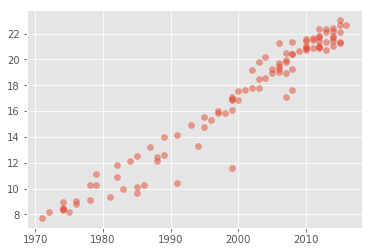

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
from sklearn import preprocessing
import re
%matplotlib inline  
plt.style.use('ggplot')

# Load data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X.shape = (X.shape[0], 1)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
Y = np.log(Y)

# Divide training and test set
N, M = X.shape
idx = int(0.8*N)
X_train = X[:idx, :]
Y_train = Y[:idx]
N_train = idx
X_test = X[idx:, :]
Y_test = Y[idx:]
N_test = N - N_train

plt.scatter(X[:, 1:], Y, alpha=0.5)

In [62]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}

transformed data{}

parameters {
    vector[M] beta;
    real log_sigma;
}

transformed parameters{
    vector[N_train] mu;
    mu <- X_train*beta;
}

model {
    Y_train ~ normal(mu, exp(log_sigma));
}

generated quantities {
    vector[N_test] Y_pred;
    Y_pred <- X_test*beta; //the y values predicted by the model
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
fit = pystan.stan(model_code=ridge_code, data=data, iter=1000, chains=1)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53a49e3d298c0515a9dcb995c0d55527 NOW.


Inference for Stan model: anon_model_53a49e3d298c0515a9dcb995c0d55527.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -547.0   40.41  156.5 -840.9 -659.0 -559.3 -443.3 -219.6     15   1.07
beta[1]      0.28    0.02   0.08   0.12   0.23   0.29   0.34   0.43     15   1.07
log_sigma   -0.64    0.03   0.13  -0.87  -0.73  -0.66  -0.56  -0.33     22   1.02
mu[0]       21.31    0.03   0.16  21.03   21.2   21.3  21.42  21.65     28   1.05
mu[1]       21.31    0.03   0.16  21.03   21.2   21.3  21.42  21.65     28   1.05
mu[2]       21.31    0.03   0.16  21.03   21.2   21.3  21.42  21.65     28   1.05
mu[3]       21.31    0.03   0.16  21.03   21.2   21.3  21.42  21.65     28   1.05
mu[4]       21.31    0.03   0.16  21.03   21.2   21.3  21.42  21.65     28   1.05
mu[5]        21.6  9.8e-3   0.11   21.4  21.52  21.59  21.66  21.84    127  

In [81]:
Y_pred = fit.extract('Y_pred')['Y_pred']
np.linalg.norm(Y_pred.mean(axis=0) - Y_test) / np.linalg.norm(Y_pred.mean(axis=0))

0.024890161197544437